# Masks

In [2]:
import BrukerMRI as bruker
import pylab as pl
import plot
#Python method of extracting raw Bruker Files
import BrukerMRI as bruker

# Modules
import pandas as pd
import pydicom as dcm
import math
import numpy as np
import matplotlib.pyplot as plt
import glob
from os.path import expanduser
import os
from matplotlib import cm
import cmath

In [2]:
# plot Style
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

#plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
COLOR = 'white'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

## Filtering K-space

In [7]:
# copy and paste entire directory but replace "\" with "/"
# Place a "/" at the end of the line
MainDir = "C:/Users/daniala/Desktop/mri/20191210_104049_MRMD_phantom_practice_1_3/"
ExpNum = 8
Experiment = bruker.ReadExperiment(MainDir, ExpNum)
acqp = Experiment.acqp
method = Experiment.method
raw_fid = Experiment.raw_fid
k_space_gen = Experiment.GenerateKspace()
k_space = Experiment.k_data
k_sp = bruker.phase_shift(120,0,k_space)[:,:,0]

### Eliptical Masks

In [8]:
def eliptical_mask(array,a,b,val_in):
    
    N_y = array.shape[0]
    N_x = array.shape[1]
    
    if val_in == 1:
            mask = np.zeros((N_y,N_x), dtype=int)
            val = 1
    elif val_in == 0:
            mask = np.ones((N_y,N_x), dtype=int)
            val = 0
            
    for k in range(0,b):
        
            for i in range(N_x):
        #((x^2)/a) + ((y^2)/b) = 1
                x_o = (i-((N_x/2)-1))
                y_p = int(((N_y/2)-1) + ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                y_n = int(((N_y/2)-1) - ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                mask[i,y_p] = val
                mask[i,y_n] = val
        
    return mask

#### Inspect Shape of the K-space array first

In [9]:
k_sp.shape

(256, 256)

### Testing Eliptical Mask Function

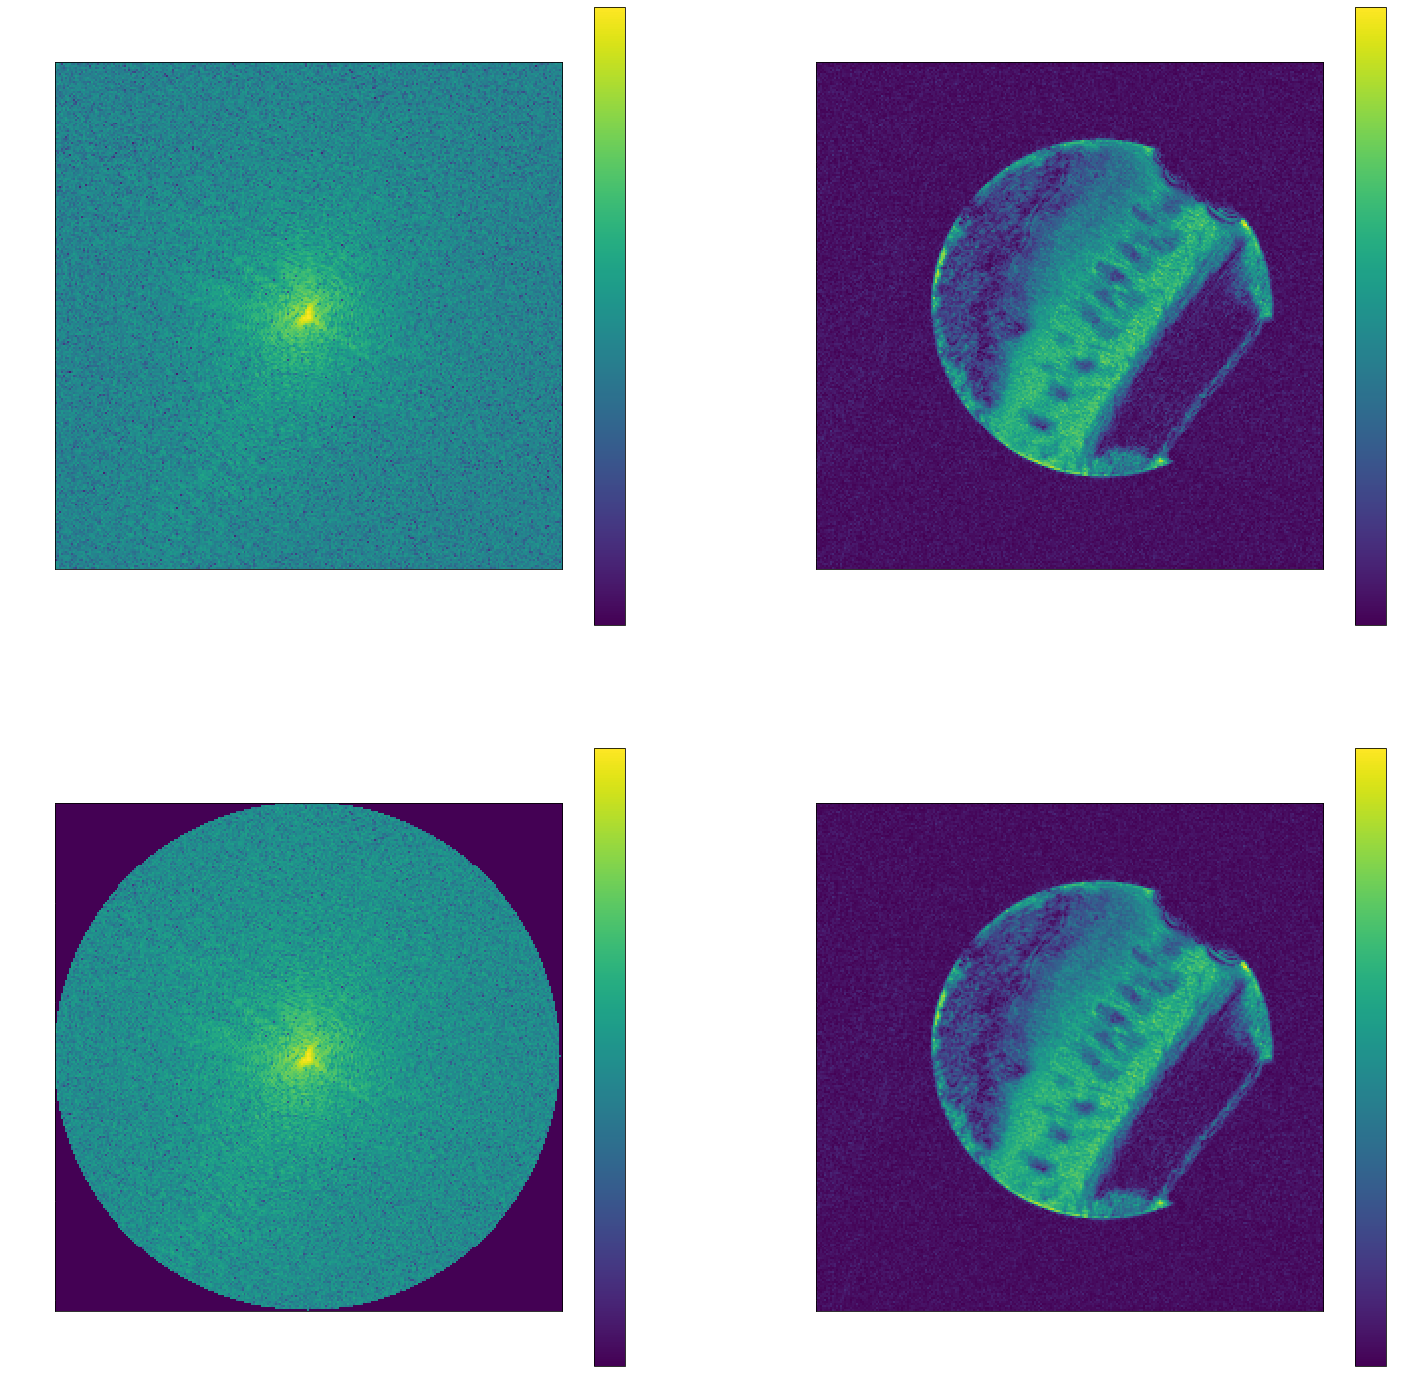

In [10]:
mask_1 = eliptical_mask(k_sp.copy(),128,128,1)
# max a and b are half the dimensions of the shape
k_mask = np.multiply(k_sp,mask_1)
k_spaces = {'Original k-space':k_sp,'Masked k-space':k_mask}
plot.comparison_k_plots(k_spaces)

#### Masking Functions directly on Arrays

In [32]:
def eliptical_zero(array,a,b):
    #a = array.shape[0]
    # selecting a range of values for b to observe the effects of masking
    N_y = array.shape[0]
    N_x = array.shape[1]
    masked_k_sp = {'Original k-space':k_sp}
    
    for b_s in range(b,4*b,b):
        array_new = array.copy()
        for k in range(0,b_s):
            for i in range(N_x):
        #((x^2)/a) + ((y^2)/b) = 1
                x_o = (i-((N_x/2)-1))
                y_p = int(((N_y/2)-1) + ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                y_n = int(((N_y/2)-1) - ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                array_new[i,y_p] = 0
                array_new[i,y_n] = 0
    
            d={'Masked with Elipse of b ' + ' = '+ str(b):array_new}
            masked_k_sp.update(d)
            
    return masked_k_sp

In [33]:
def eliptical_masking_range(array,a,b):
    #a = array.shape[0]
    # selecting a range of values for b to observe the effects of masking
    N_y = array.shape[0]
    N_x = array.shape[1]
    masked_k_sp = {'Original k-space':k_sp}
    array_new = array.copy()
    
    for b_s in range(b,4*b,b):
        mask_zero = np.zeros((N_y,N_x), dtype=int)
        for k in range(0,b_s):
            for i in range(N_x):
        #((x^2)/a) + ((y^2)/b) = 1
            
                x_o = (i-((N_x/2)-1))
                y_p = int(((N_y/2)-1) + ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                y_n = int(((N_y/2)-1) - ((k/a)*np.sqrt((a-x_o)*(a+x_o))))
                mask_zero[i,y_p] = 1
                mask_zero[i,y_n] = 1
            
            masked = np.multiply(mask_zero,array_new)
            d={'Masked with Elipse of b ' + ' = '+str(b):masked}
            masked_k_sp.update(d)
    return masked_k_sp

In [34]:
m_k_sp = k_sp.copy()

#### Masking the Middle

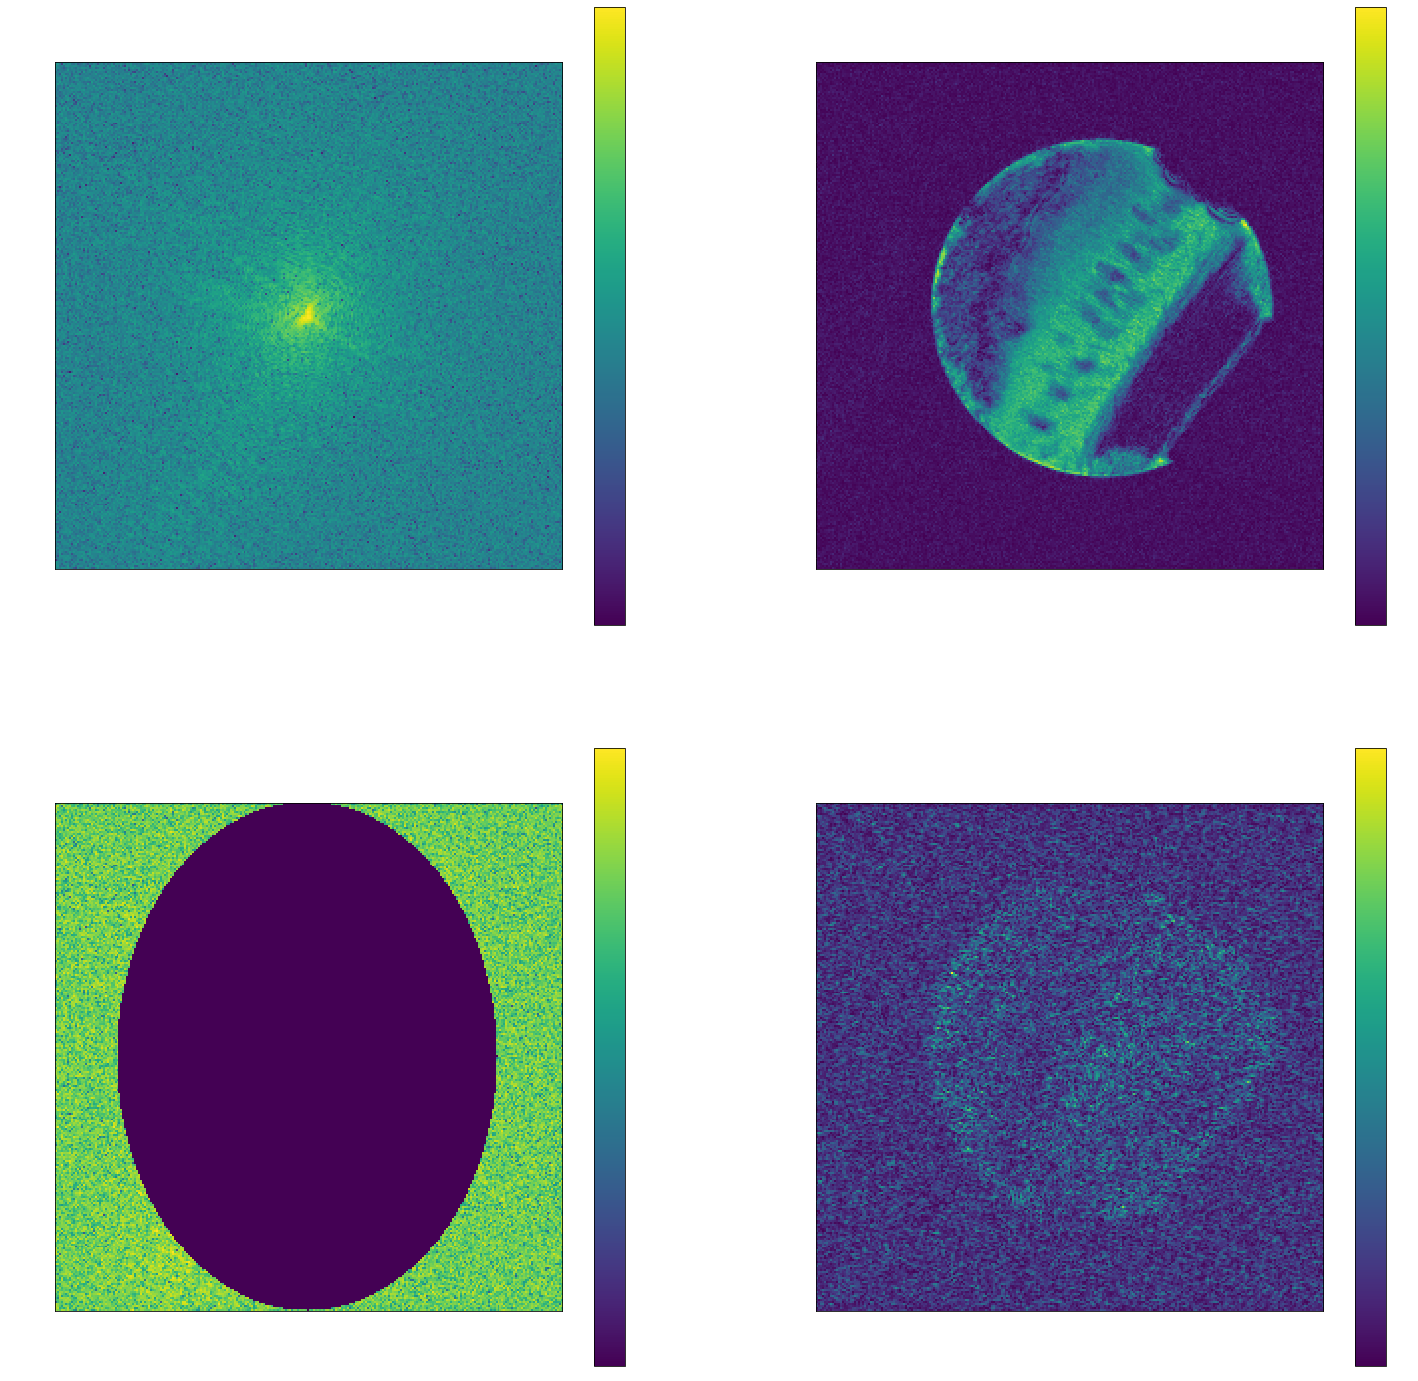

In [35]:
plot.comparison_k_plots(eliptical_zero(m_k_sp,128,32))

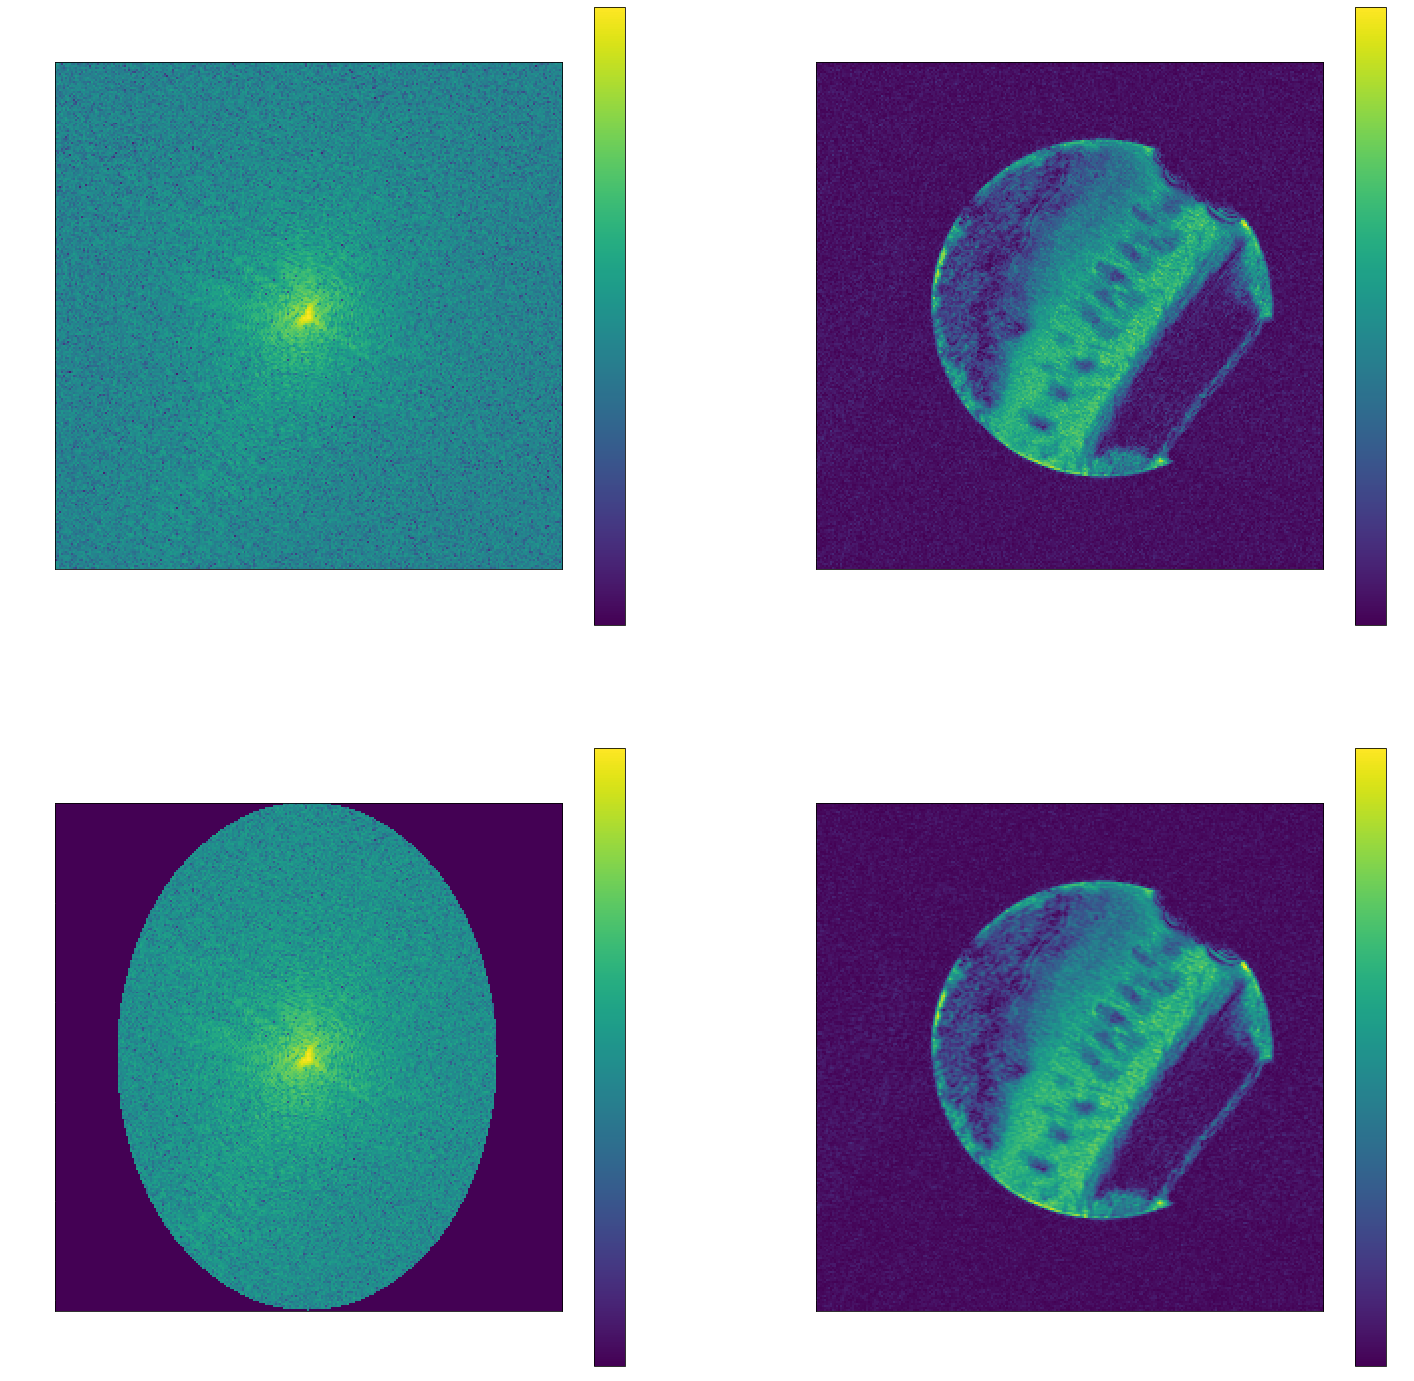

In [36]:
plot.comparison_k_plots(eliptical_masking_range(m_k_sp,128,32))

### Alternative Masking Methods

In [17]:
# A Conventional coordinate system with centre axis (0,0) in the form of a matrix

x = np.linspace(-256/2, (256/2)-1,256)
y = np.linspace(-256/2, (256/2)-1,256)
xv, yv = np.meshgrid(x, y)

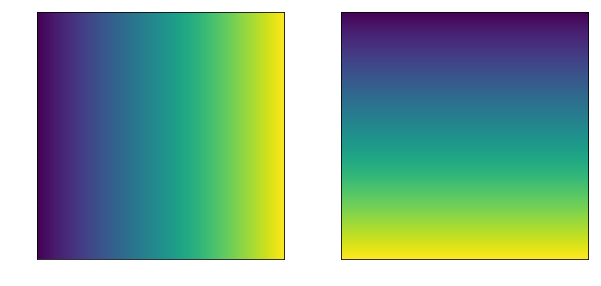

In [18]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(xv)

plt.subplot(222)
plt.imshow(yv)

#### Meshgrid Functions

In [21]:
def eliptical_mesh_mask(array,a_or_b,val_inside):
    
    # Creating the array mesh based on the input array
    masked_mesh = {'Original k-space':k_sp}
    array_new = array.copy()
    N_y = array_new.shape[0]
    N_x = array_new.shape[1]
    x = np.linspace(-N_x/2, (N_x/2)-1,N_x)
    y = np.linspace(-N_y/2, (N_y/2)-1,N_y)
    xv, yv = np.meshgrid(x, y)
    
    for var in range(32,128,32):
        if a_or_b == 'a':
            a=127
            z = np.power(xv,2)/np.power(a,2) + np.power(yv,2)/np.power(var,2)
        
        elif a_or_b == 'b':
            b=127
            z = np.power(xv,2)/np.power(var,2) + np.power(yv,2)/np.power(b,2)
            
        z0 = z.copy()
        idx = (z0 <= 1)
        idx_0 = (z0 > 1)
        
        if (val_inside == 1):
            z0[idx_0] = 0
            z0[idx] = 1
            
        elif val_inside == 0:
            z0[idx_0] = 1
            z0[idx] = 0
        
        masked_m = np.multiply(z0,array_new)
        d={'Masked with Elipse of ' + a_or_b + ' = '+str(var):masked_m}
        masked_mesh.update(d)
    
    return masked_mesh

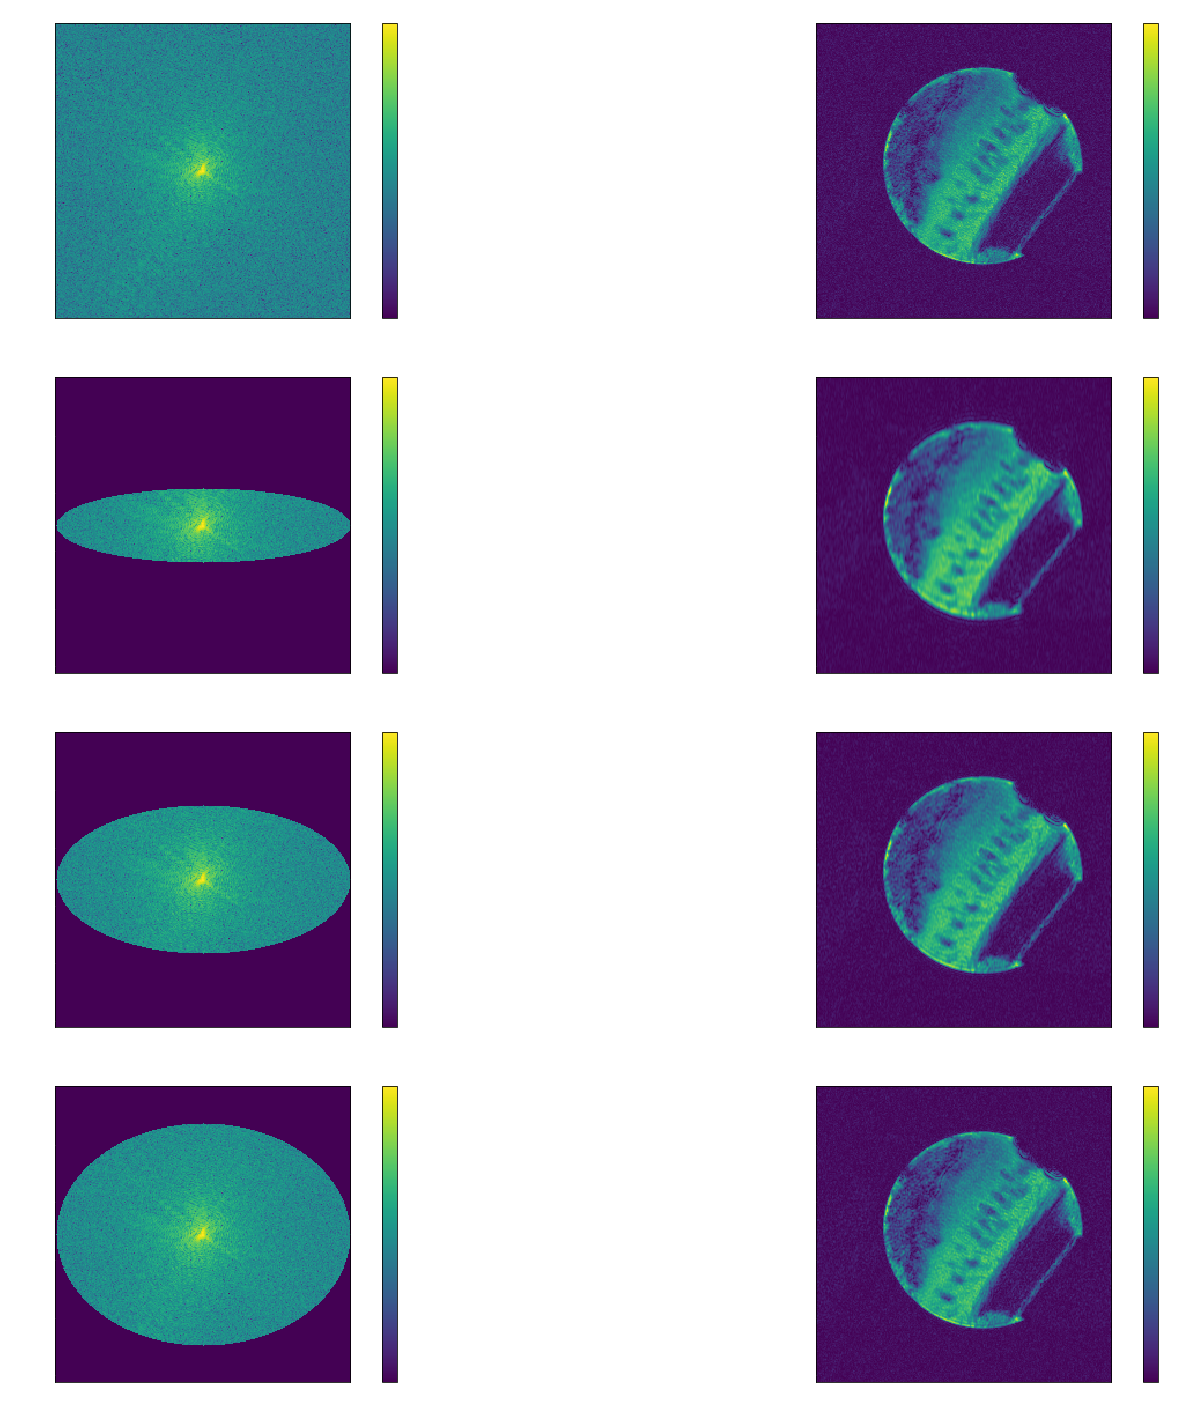

In [22]:
plot.comparison_k_plots(eliptical_mesh_mask(k_sp,'a',1))

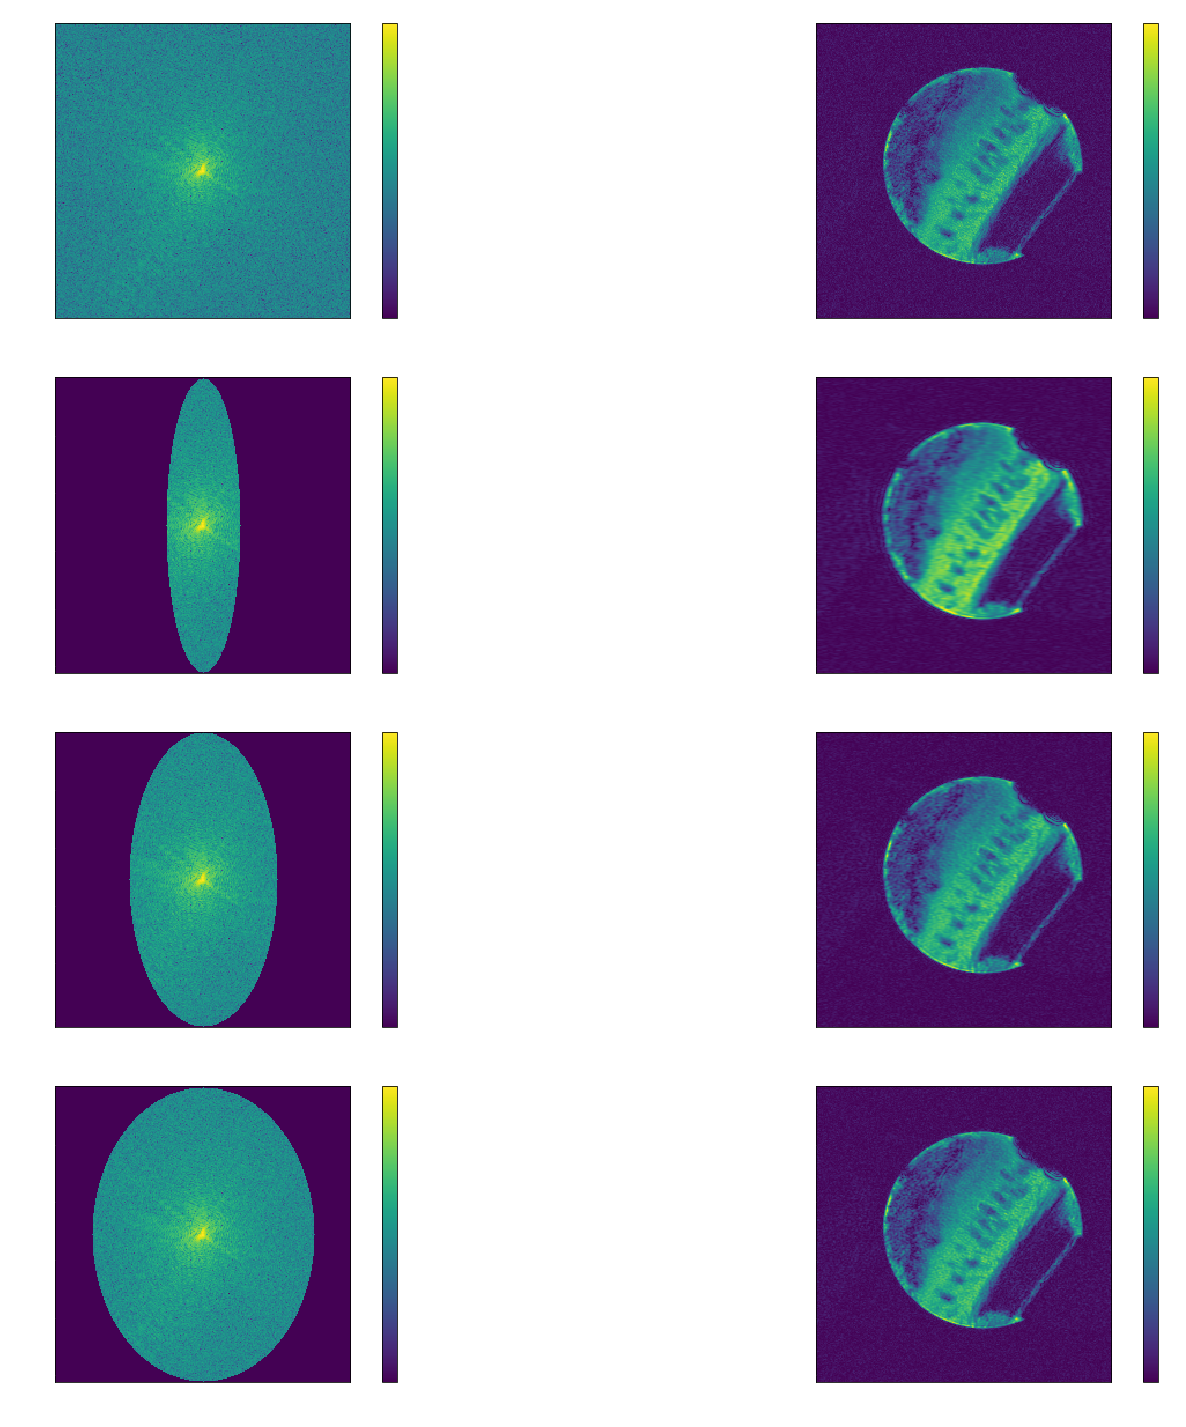

In [37]:
plot.comparison_k_plots(eliptical_mesh_mask(k_sp,'b',1))

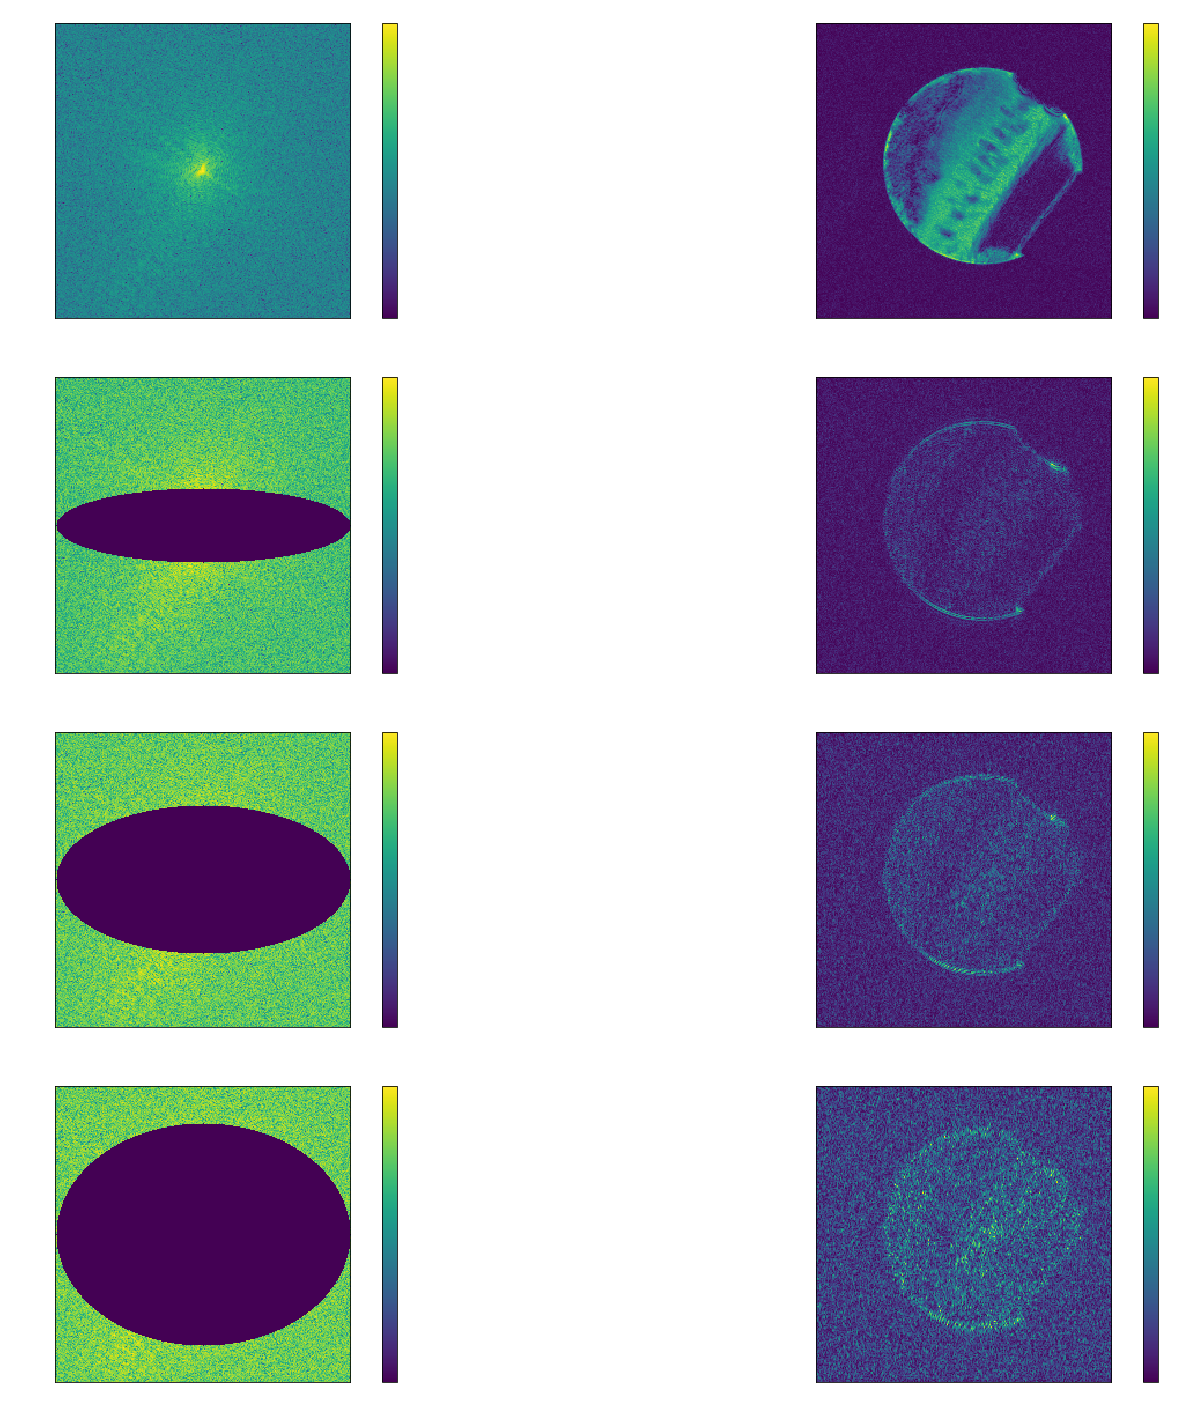

In [38]:
plot.comparison_k_plots(eliptical_mesh_mask(k_sp,'a',0))

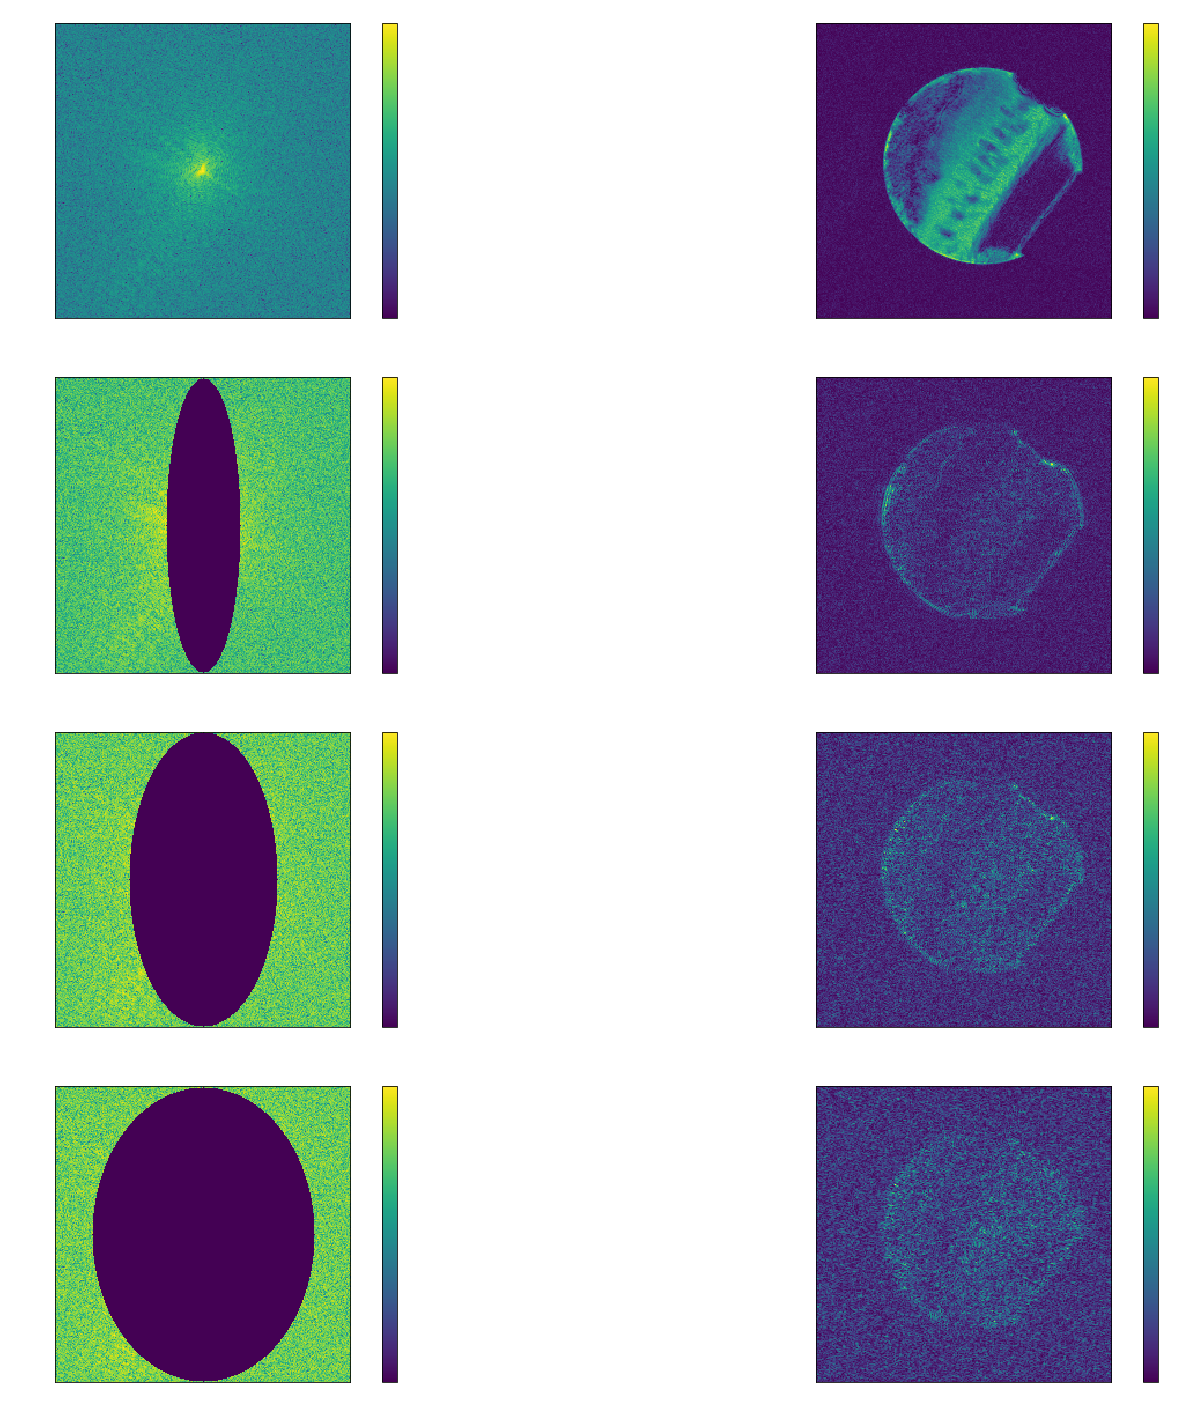

In [39]:
plot.comparison_k_plots(eliptical_mesh_mask(k_sp,'b',0))

## Square Masks

In [3]:
x = np.linspace(-256/2, (256/2)-1,256)
y = np.linspace(-256/2, (256/2)-1,256)
xv, yv = np.meshgrid(x, y)

In [4]:
t = np.pi/4
z = abs(xv*np.cos(t)-yv*np.sin(t))+abs(yv*np.cos(t)+xv*(np.sin(t)))

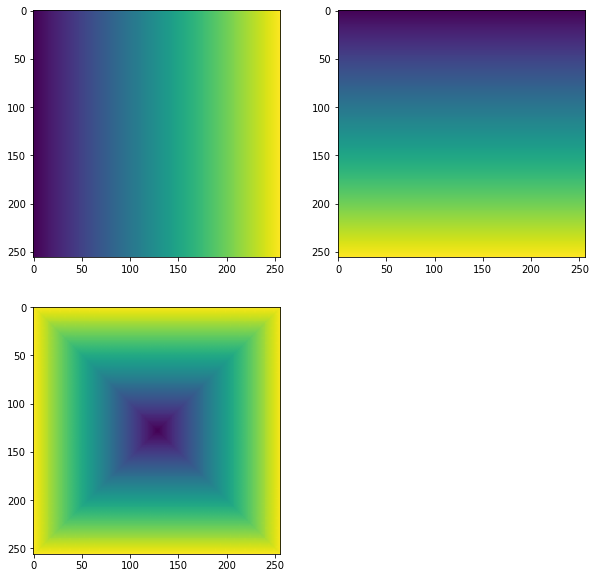

In [5]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(xv)

plt.subplot(222)
plt.imshow(yv)

plt.subplot(223)
plt.imshow(z)

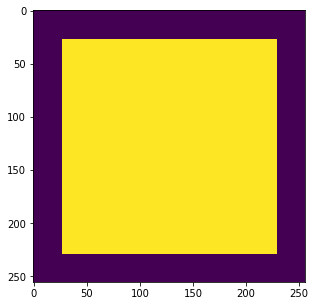

In [6]:
z0 = z.copy()
idx = (z0 > 144)
idx_0 = (z0 <= 144)
z0[idx_0] = 1
z0[idx] = 0
plt.figure(figsize=(5,5))
plt.imshow(z0)

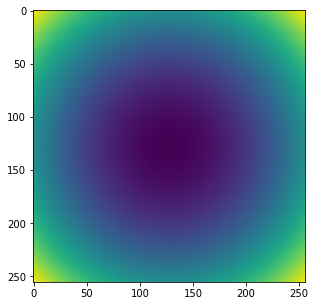

In [8]:
z_circle = np.power(xv,2) + np.power(yv,2)
plt.figure(figsize=(5,5))
plt.imshow(z_circle)

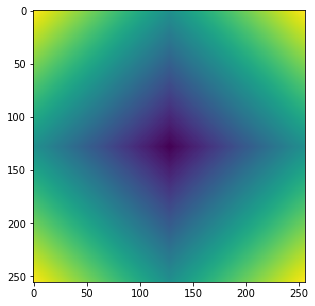

In [9]:
z_sq = abs(xv)+abs(yv)
plt.figure(figsize=(5,5))
plt.imshow(z_sq)